### Apply DL model using DEA data
follows on from DL_model_DEA_develop.ipynb

In [34]:
import datetime
import numpy as np
import geopandas as gpd
from matplotlib import pyplot

import tensorflow
from tensorflow import keras

#### Load keras model
classes 0 = CTV, 1 = NTV, 2 = NAV, 3 = AS, 4 = BS, 5 = W

In [35]:
# load model
model = keras.models.load_model('./keras_level3_e30_20201204T115102.mdl')

# Check its architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 32768)             23587712  
_________________________________________________________________
dense (Dense)                (None, 32)                1048608   
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1

#### Predict chip using model
classes 0 = CTV, 1 = NTV, 2 = NAV, 3 = AS, 4 = BS, 5 = W

In [36]:
# Get overall stats for each band - Only used for visualisation.
mean_red = np.mean(test_data[:,:,:,0])
std_red = np.std(test_data[:,:,:,0])
mean_green = np.mean(test_data[:,:,:,1])
std_green = np.std(test_data[:,:,:,1])
mean_blue = np.mean(test_data[:,:,:,2])
std_blue = np.std(test_data[:,:,:,2])

image_stats = {"red" : (mean_red, std_red),
               "green" : (mean_green, std_green),
               "blue" : (mean_blue, std_blue)}

def apply_std_stretch(in_array, col="red"):
    mean = image_stats[col][0]
    stdev = image_stats[col][1]
    
    sd_min = mean - 2*stdev
    sd_max = mean + 2*stdev
    sd_range = sd_max - sd_min

    out_array = (in_array / sd_range) * 255
    out_array[out_array < 0] = 0
    out_array[out_array > 255] = 255

    return out_array.astype(np.uint8)


def get_rgb(in_image):
    red = apply_std_stretch(in_image[:,:,0], "red")
    green = apply_std_stretch(in_image[:,:,1], "green")
    blue = apply_std_stretch(in_image[:,:,2], "blue")

    return np.dstack([red, green, blue])


In [37]:
# Load associated test data with model development
test_data = np.load('./test_data.npy')
test_data_labels = np.load('./test_data_labels.npy')

# Randomly select
sample_id = np.random.randint(0, test_data.shape[0])
sample_id

439

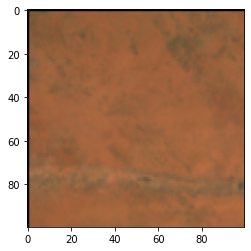

In [38]:
pyplot.imshow(get_rgb(test_data[sample_id,:,:,:]))

In [39]:
# # get a slice of the data, between sample_id and sample_id+1
# # output gives a % confidence of being in a particular class (i.e. 6 values, relating to level 3 classes)
# model.predict(keras.applications.resnet50.preprocess_input(test_data[sample_id:sample_id+1,:,:,:]))
model.predict(test_data[sample_id:sample_id+1,:,:,:])

array([[0.19202231, 0.12382468, 0.064359  , 0.09797944, 0.2560927 ,
        0.2657218 ]], dtype=float32)

#### Apply model to DEA sen-2 area using image chips
- load DEA sen-2 area
- break into chips
- classify each chip
- get original area with classifications

In [55]:
# Load sen-2 AOI and cog, then put into read function below
import os, sys
import datacube
import yaml

sys.path.append('/home/jovyan/Scripts')
from dea_datahandling import load_ard
from datacube.storage import masking
from datacube.helpers import write_geotiff

dc = datacube.Datacube(app='Apply DL model using DEA data')


yaml_sites_file = os.path.abspath("/home/jovyan/development/chris_leaust_testing/notebooks/misc/au_test_sites.yaml")

with open(yaml_sites_file, "r") as f:
    site_config = yaml.safe_load(f)

site_name = "Little Perth"
extent_x = [site_config[site_name]["min_x"],
            site_config[site_name]["max_x"]]
extent_y = [site_config[site_name]["min_y"],
            site_config[site_name]["max_y"]]

output_crs = 'EPSG:3577'
res = (-10, 10)
time = ("2018-01-01", "2018-03-31")
measurements = ['nbart_red', 'nbart_green', 'nbart_blue']
query =({'time': time,
         'x':extent_x,
         'y':extent_y,
         'measurements': measurements,
         'output_crs':output_crs,
         'resolution':res})


# time = ('2018-01-01', '2018-02-01')
# measurements = ['nbart_red', 'nbart_green', 'nbart_blue']
# resolution = (-10, 10)
# output_crs = 'EPSG:3577'

# # Perth
# x = (-1550000, -1450000)
y = (-3650000, -3550000)


# x = (153.45, 153.47)
# y = (-28.90, -28.92)

# query = {'x':x,
#          'y':y,
#          'time': time,
#          'measurements': measurements,
#          'resolution': resolution,
#          'output_crs': output_crs
#         }
query

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


{'time': ('2018-01-01', '2018-03-31'),
 'x': [-1520000, -1510000],
 'y': [-3590000, -3580000],
 'measurements': ['nbart_red', 'nbart_green', 'nbart_blue'],
 'output_crs': 'EPSG:3577',
 'resolution': (-10, 10)}

In [56]:
# res = (-100, 100)
# crs = "EPSG:3577"
# time = ("2015-01-01", "2015-12-31")
# sensor = 'ls8'
# query =({'x':x,
#         'y':y,
#         'crs':crs,
#         'resolution':res})

ds = load_ard(dc=dc,
              products=["s2a_ard_granule", "s2b_ard_granule"],
              min_gooddata=0.90,  # only take uncloudy scenes
              group_by='solar_day',
              crs="EPSG:3577",
              **query)




Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step
Filtering to 1 out of 18 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time steps


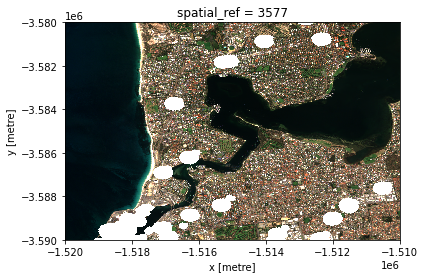

In [57]:
ds = masking.mask_invalid_data(ds).squeeze().drop('time')
ds[['nbart_red', 'nbart_green', 'nbart_blue']].to_array().plot.imshow(robust=True)

In [71]:
ds

<xarray.Dataset>
Dimensions:      (x: 1000, y: 1000)
Coordinates:
  * y            (y) float64 -3.58e+06 -3.58e+06 ... -3.59e+06 -3.59e+06
  * x            (x) float64 -1.52e+06 -1.52e+06 ... -1.51e+06 -1.51e+06
    spatial_ref  int32 3577
Data variables:
    nbart_red    (y, x) float32 41.0 48.0 43.0 37.0 ... 1360.0 1231.0 1190.0
    nbart_green  (y, x) float32 225.0 215.0 163.0 179.0 ... 1187.0 931.0 1194.0
    nbart_blue   (y, x) float32 377.0 353.0 303.0 290.0 ... 956.0 690.0 967.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [58]:
write_geotiff(filename=site_name+'_2018_DL_test.tif', dataset=ds)

/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


In [103]:
from rios.imagereader import ImageReader
inImgs = './Little Perth_2018_DL_test.tif'

chip_size = 100
inImgBands = 3


inImgs = list()
inImgBands = list()

inImgs.append(inImgs)
inImgBands.append([1])
n_img_bands = 0
for inImgInfo in imgFileInfo:
    inImgs.append(inImgInfo.fileName)
    inImgBands.append(inImgInfo.bands)
    n_img_bands = n_img_bands + len(inImgInfo.bands)
nImgs = len(imgFileInfo)


reader = ImageReader(inImgs, windowxsize=chip_size, windowysize=chip_size, overlap=scn_overlap, layerselection=inImgBands)

# chip size divided by 2
scn_overlap = chip_size // 2


NameError: name 'imgFileInfo' is not defined

In [102]:
reader

In [100]:
writer = None
feat2cls = None

# number of bands in image (rgb = 3)
n_img_bands = 3

import tqdm

for (info, block) in tqdm.tqdm(reader):
    # breaks up the input image into chips
    classMskArr = block[0]
    
    # get shape of the chip
    blk_shape = classMskArr.shape

    # make an array of same size with all 0 values
    if feat2cls is None:
        feat2cls = np.zeros([1, chip_size, chip_size, n_img_bands], dtype=np.float32)
    else:
        feat2cls[...] = 0

    chip_mask = classMskArr[0, scn_overlap:scn_overlap+chip_size, scn_overlap:scn_overlap+chip_size]
    print(chip_mask)
    # If there are no valid pixels in the block at all then no point running prediction
    # set all output valies to 0.

  0%|          | 0/100 [00:00<?, ?it/s]


IndexError: too many indices for array